In [162]:
from mplsoccer.pitch import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from highlight_text import HighlightText, ax_text, fig_text
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import matplotlib.patheffects as path_effects

In [163]:
data = pd.read_csv("LaLiga_23_24.csv" , low_memory=False)
data['x'] = data['x']*1.2
data['y'] = data['y']*.8
data['endX'] = data['endX']*1.2
data['endY'] = data['endY']*.8

In [164]:
def add_carries(game_df):
   min_dribble_length: float = 0.0
   max_dribble_length: float = 100.0
   max_dribble_duration: float = 20.0
   game_df['time_seconds']=game_df['minute']*60+game_df['second']
   next_actions = data.shift(-1)
   same_game=game_df.gameId==next_actions.gameId
   same_team = game_df.teamId == next_actions.teamId
   dx = game_df.endX - next_actions.x
   dy = game_df.endY- next_actions.y
   far_enough=dy** 2 + dy** 2 >= min_dribble_length** 2
   not_too_far = dx ** 2+ dy** 2<= max_dribble_length ** 2
   dt = next_actions.time_seconds - game_df.time_seconds
   same_phase = dt < max_dribble_duration
   same_period = game_df.period == next_actions.period
   dribble_idx = same_team & far_enough & not_too_far & same_phase & same_period&same_game
   dribbles = pd.DataFrame()
   prev = game_df[dribble_idx]
   nex= next_actions[dribble_idx]
   dribbles['gameId' ] = nex.gameId
   dribbles['period' ] = nex.period
   for cols in ['expandedMinute']:
      dribbles[cols] = nex[cols]
   for cols in ['passKey','assist']:
      dribbles[ cols] = [True for _ in range (len (dribbles))]
   dribbles['isTouch'] = [True for _ in range (len (dribbles))]
   morecols = ['playerId', 'team','player']
   for cols in morecols:
      dribbles[cols] = nex[cols]
   #dribbles['action_id'] = prev.eventId + 0.1
   dribbles['time_seconds' ] = (prev.time_seconds + nex.time_seconds) / 2
   dribbles['teamId'] = nex.teamId
   dribbles['playerId']= nex.playerId
   dribbles['player' ]= nex.player
   dribbles['x'] = prev.endX
   dribbles['y']= prev.endY
   dribbles['endX'] = nex.x
   dribbles['endY'] = nex.y
   dribbles['type'] = ['Carry' for _ in range(len(dribbles))]
   dribbles['outcomeType'] = ['Successful' for _ in range(len(dribbles))]
   dribbles['qualifiers']=[{} for _ in range(len(dribbles))]
   game_df=pd.concat([game_df,dribbles], ignore_index=True,sort=False)
   game_df=game_df.sort_values(['gameId','period']).reset_index(drop=True)
   game_df['action_id']=range(len(game_df))
   return game_df

In [165]:
data = add_carries(data)

In [166]:
data_carries = data[data['type'] == 'Carry']

In [167]:
data_passes = data[(data['type'] == 'Pass') & (data['outcomeType'] == 'Successful')]

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch, FontManager, add_image

left_halfspace_x_min = 60
left_halfspace_x_max = 60 + 42
left_halfspace_y_min = 50
left_halfspace_y_max = 50 + 12

right_halfspace_x_min = 60
right_halfspace_x_max = 60 + 42
right_halfspace_y_min = 18
right_halfspace_y_max = 18 + 12

# Add columns to identify half-space passes and carries
data_passes['in_rhs'] = (data_passes['x'].between(right_halfspace_x_min, right_halfspace_x_max) & 
                         data_passes['y'].between(right_halfspace_y_min, right_halfspace_y_max))
data_passes['in_lhs'] = (data_passes['x'].between(left_halfspace_x_min, left_halfspace_x_max) & 
                         data_passes['y'].between(left_halfspace_y_min, left_halfspace_y_max))
data_passes['into_rhs'] = (data_passes['endX'].between(right_halfspace_x_min, right_halfspace_x_max) & 
                           data_passes['endY'].between(right_halfspace_y_min, right_halfspace_y_max) & 
                           (data_passes['in_rhs'] == False))
data_passes['into_lhs'] = (data_passes['endX'].between(left_halfspace_x_min, left_halfspace_x_max) & 
                           data_passes['endY'].between(left_halfspace_y_min, left_halfspace_y_max) & 
                           (data_passes['in_lhs'] == False))

data_carries['in_rhs'] = (data_carries['x'].between(right_halfspace_x_min, right_halfspace_x_max) & 
                          data_carries['y'].between(right_halfspace_y_min, right_halfspace_y_max))
data_carries['in_lhs'] = (data_carries['x'].between(left_halfspace_x_min, left_halfspace_x_max) & 
                          data_carries['y'].between(left_halfspace_y_min, left_halfspace_y_max))
data_carries['into_rhs'] = (data_carries['endX'].between(right_halfspace_x_min, right_halfspace_x_max) & 
                            data_carries['endY'].between(right_halfspace_y_min, right_halfspace_y_max) & 
                            (data_carries['in_rhs'] == False))
data_carries['into_lhs'] = (data_carries['endX'].between(left_halfspace_x_min, left_halfspace_x_max) & 
                            data_carries['endY'].between(left_halfspace_y_min, left_halfspace_y_max) & 
                            (data_carries['in_lhs'] == False))

def calculate_progressive_actions(df):
    df_prog = df.copy()
    df_prog['beginning'] = np.sqrt(np.square(120 - df_prog['x']) + np.square(40 - df_prog['y']))
    df_prog['end'] = np.sqrt(np.square(120 - df_prog['endX']) + np.square(40 - df_prog['endY']))
    df_prog['progressive'] = (df_prog['end'] / df_prog['beginning']) < 0.75
    return df_prog[df_prog['progressive']]

prog_rhs_passes = calculate_progressive_actions(data_passes[data_passes['in_rhs']])
prog_lhs_passes = calculate_progressive_actions(data_passes[data_passes['in_lhs']])
prog_rhs_carries = calculate_progressive_actions(data_carries[data_carries['in_rhs']])
prog_lhs_carries = calculate_progressive_actions(data_carries[data_carries['in_lhs']])

# Group and aggregate
prog_rhs_passes_grouped = prog_rhs_passes.groupby(['playerId', 'player', 'team']).size().reset_index(name='prog_rhs_passes')
prog_lhs_passes_grouped = prog_lhs_passes.groupby(['playerId', 'player', 'team']).size().reset_index(name='prog_lhs_passes')
prog_rhs_carries_grouped = prog_rhs_carries.groupby(['playerId', 'player', 'team']).size().reset_index(name='prog_rhs_carries')
prog_lhs_carries_grouped = prog_lhs_carries.groupby(['playerId', 'player', 'team']).size().reset_index(name='prog_lhs_carries')

prog_result_df_rhs = pd.merge(prog_rhs_passes_grouped, prog_rhs_carries_grouped, on=['playerId', 'player', 'team'], how='outer').fillna(0)
prog_result_df_rhs['prog_rhs_actions'] = prog_result_df_rhs['prog_rhs_passes'] + prog_result_df_rhs['prog_rhs_carries']

prog_result_df_lhs = pd.merge(prog_lhs_passes_grouped, prog_lhs_carries_grouped, on=['playerId', 'player', 'team'], how='outer').fillna(0)
prog_result_df_lhs['prog_lhs_actions'] = prog_result_df_lhs['prog_lhs_passes'] + prog_result_df_lhs['prog_lhs_carries']

combined_prog_df = pd.merge(prog_result_df_rhs, prog_result_df_lhs, on=['playerId', 'player', 'team'], how='outer').fillna(0)
combined_prog_df['prog_HS_actions'] = combined_prog_df['prog_rhs_actions'] + combined_prog_df['prog_lhs_actions']

info = pd.read_csv("T5 Leagues Mins 23-24.csv")
info['90s'] = info['Mins'] / 90

combined_prog_df = pd.merge(combined_prog_df, info, on=['player', 'team'], how='left')
combined_prog_df['prog_act_HS_p90'] = combined_prog_df['prog_HS_actions'] / combined_prog_df['90s']
#combined_prog_df['prog_lhs_actions_p90'] = combined_prog_df['prog_lhs_actions'] / combined_prog_df['90s']
combined_prog_df = combined_prog_df[(combined_prog_df['90s'] >= 15) & (combined_prog_df['position'] != 'GK')
                                    ]


combined_prog_df = combined_prog_df.drop_duplicates(subset=['player'])
top_12_prog_HS = combined_prog_df.sort_values("prog_act_HS_p90", ascending=False).head(12)

top_12_prog_HS

/var/folders/yd/kz4hmn8n5d102wb_dk7p1gf00000gn/T/ipykernel_37825/3410168792.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_passes['in_rhs'] = (data_passes['x'].between(right_halfspace_x_min, right_halfspace_x_max) &
/var/folders/yd/kz4hmn8n5d102wb_dk7p1gf00000gn/T/ipykernel_37825/3410168792.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_passes['in_lhs'] = (data_passes['x'].between(left_halfspace_x_min, left_halfspace_x_max) &
/var/folders/yd/kz4hmn8n5d102wb_dk7p1gf00000gn/T/ipykernel_3

,playerId,player,team,prog_rhs_passes,prog_rhs_carries,prog_rhs_actions,prog_lhs_passes,prog_lhs_carries,prog_lhs_actions,prog_HS_actions,Unnamed: 0,age,position,Mins,Passing Accuracy,90s,prog_act_HS_p90
259,402197.0,Pedri,Barcelona,18.0,3.0,21.0,16.0,2.0,18.0,39.0,646,21,AM(CL),1476,87.8,16.400000,2.378049
79,125547.0,Rodrigo De Paul,Atletico,33.0,3.0,36.0,14.0,1.0,15.0,51.0,681,30,"AM(CLR),FW",2088,85.7,23.200000,2.198276
6,20874.0,Luka Modric,Real Madrid,14.0,1.0,15.0,16.0,5.0,21.0,36.0,643,38,M(C),1688,91.1,18.755556,1.919431
120,279423.0,Frenkie de Jong,Barcelona,8.0,3.0,11.0,21.0,2.0,23.0,34.0,601,27,"D(C),DMC",1644,93.1,18.266667,1.861314
44,91242.0,Iago Aspas,Celta Vigo,31.0,8.0,39.0,11.0,5.0,16.0,55.0,621,36,"AM(CR),FW",2716,78.4,30.177778,1.822533
33,82989.0,Isco,Real Betis,19.0,4.0,23.0,15.0,7.0,22.0,45.0,586,32,"M(CLR),FW",2340,86.2,26.000000,1.730769
227,381594.0,Samuel Lino,Atletico,1.0,0.0,1.0,25.0,13.0,38.0,39.0,639,24,"D(L),M(LR),FW",2092,83.3,23.244444,1.677820
13,31772.0,Toni Kroos,Real Madrid,7.0,1.0,8.0,31.0,0.0,31.0,39.0,602,34,M(C),2130,94.7,23.666667,1.647887
141,300447.0,Raphinha,Barcelona,11.0,8.0,19.0,3.0,2.0,5.0,24.0,625,27,"AM(LR),FW",1373,80.9,15.255556,1.573197
4,16942.0,Óscar Trejo,Rayo Vallecano,5.0,3.0,8.0,16.0,0.0,16.0,24.0,968,36,"M(CLR),FW",1385,84.9,15.388889,1.559567


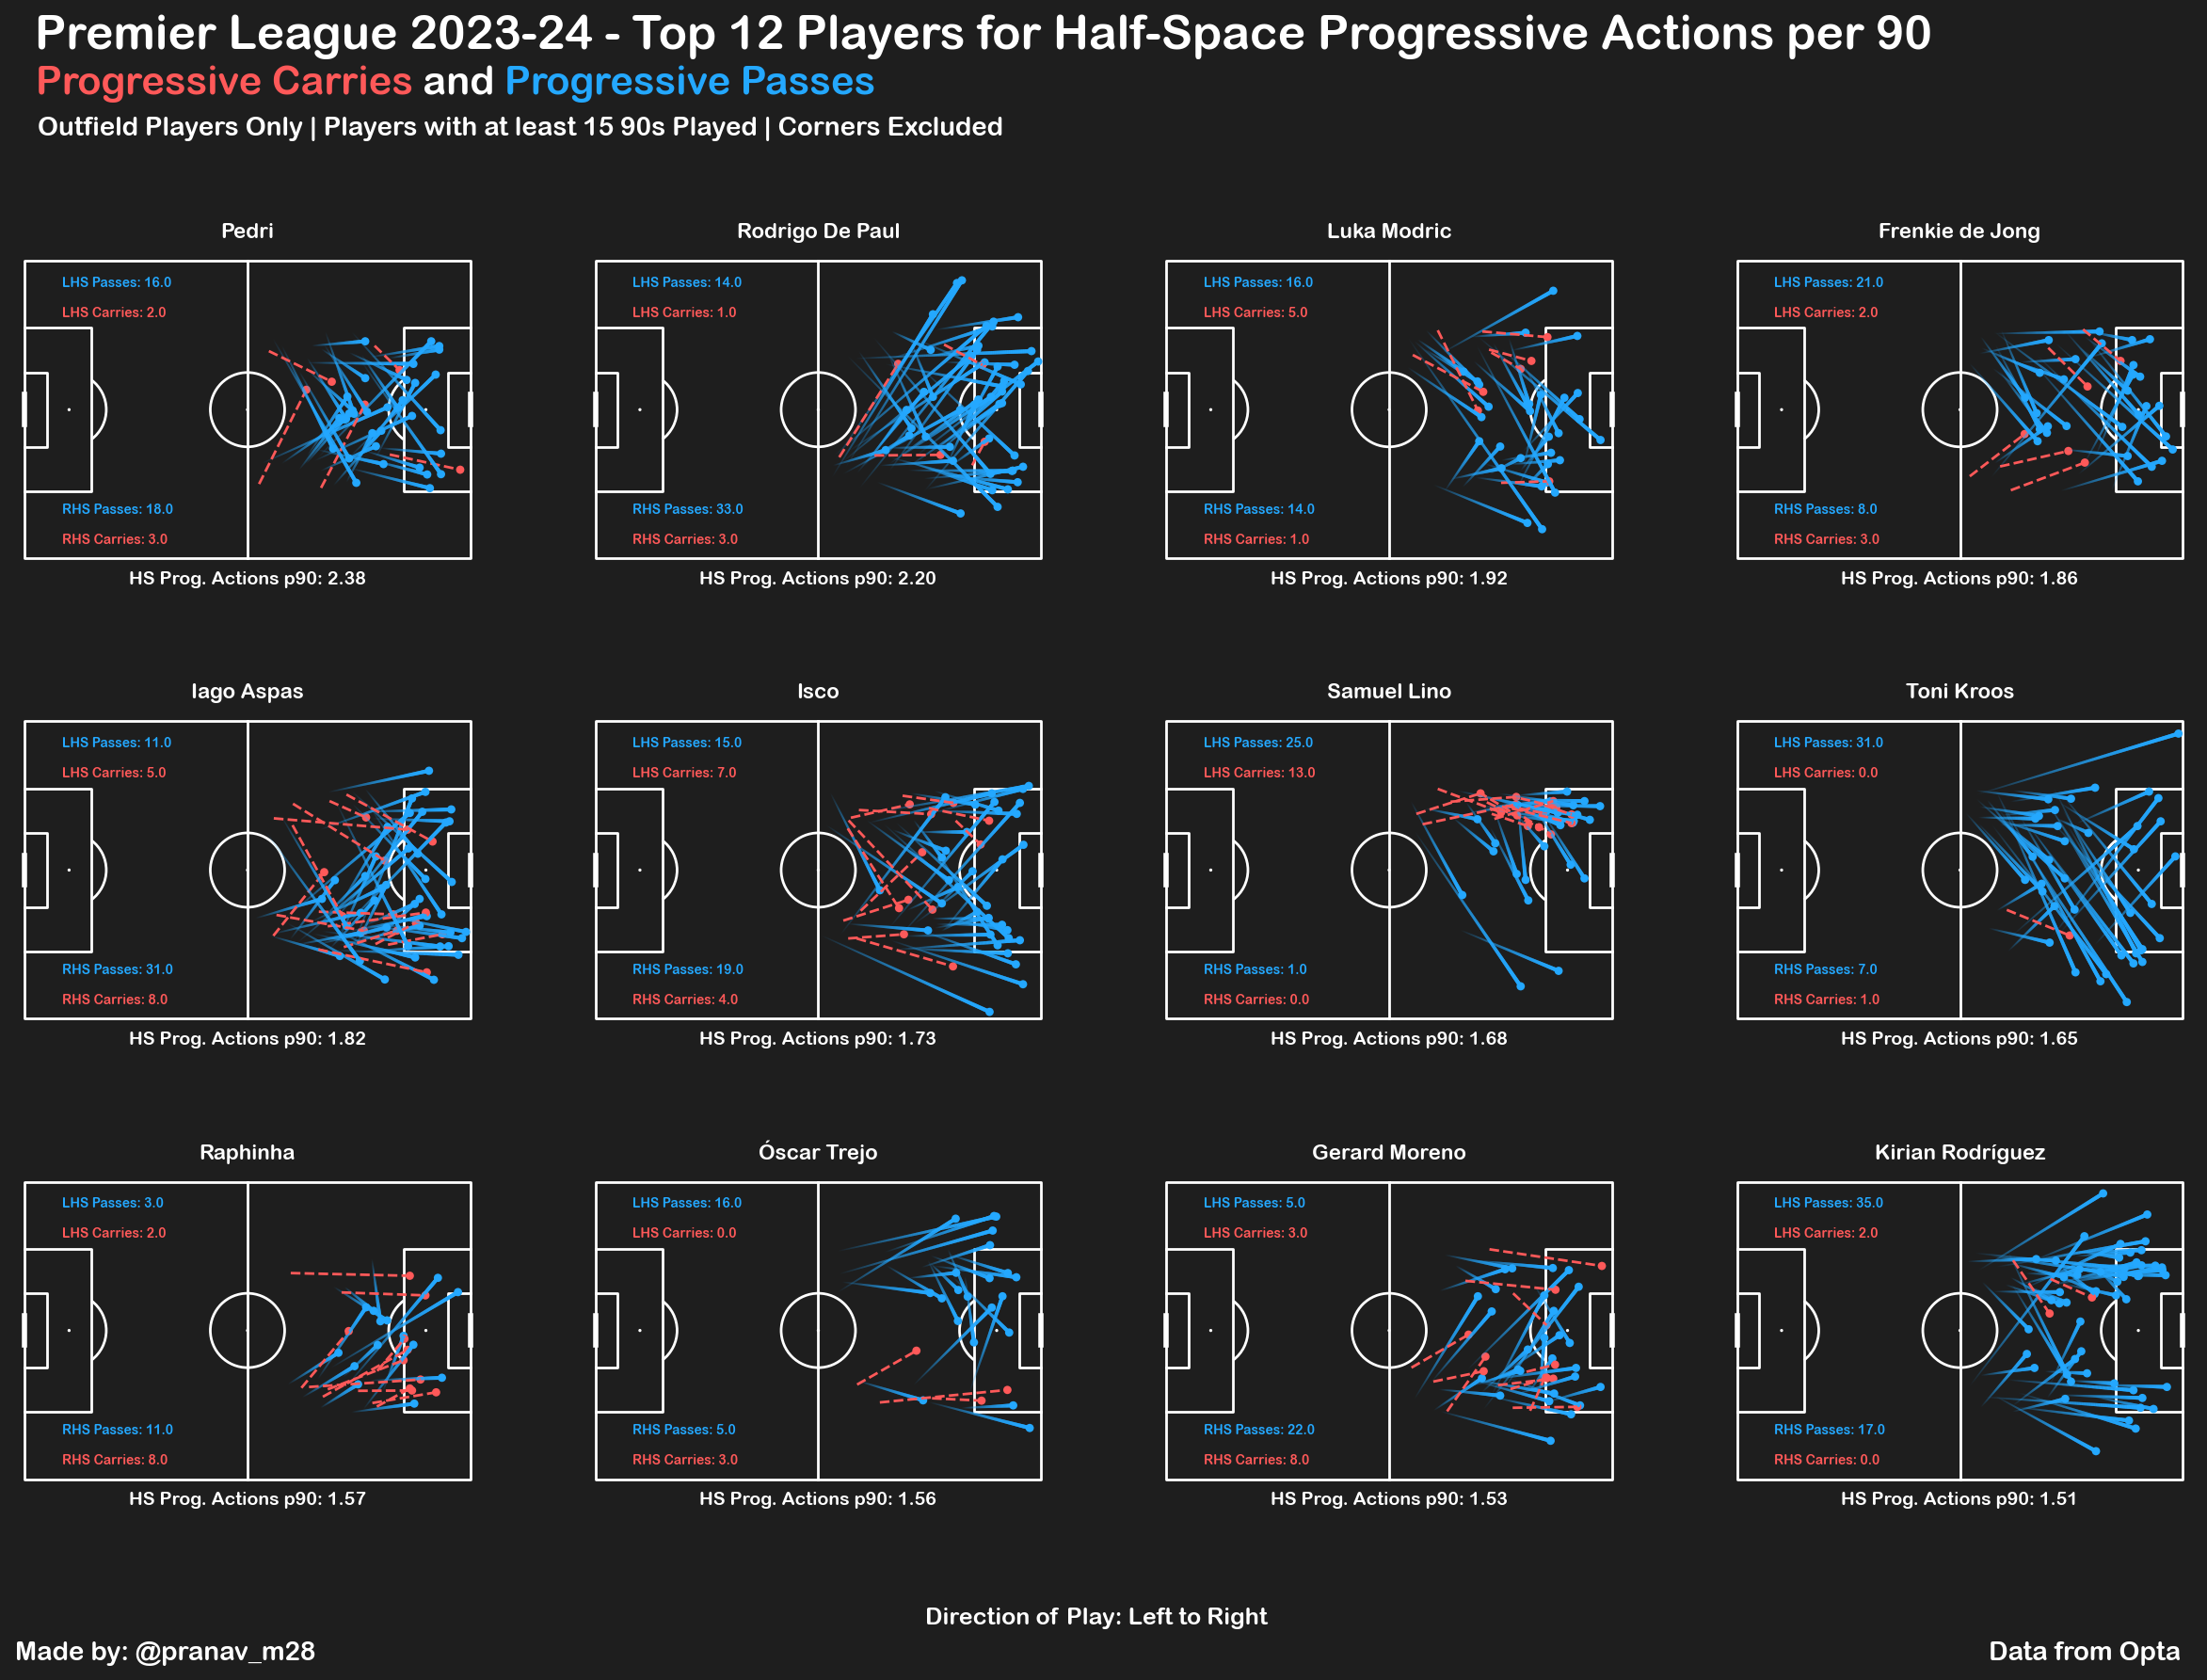

In [175]:
fig, axs = plt.subplots(3, 4, figsize=(30, 18))
fig.set_facecolor('#1e1e1e')

for ax, (_, player_data) in zip(axs.flatten(), top_12_prog_HS.iterrows()):
    player_id = player_data['playerId']
    player_name = player_data['player']
    prog_rhs_passes_count = player_data['prog_rhs_passes']
    prog_rhs_carries_count = player_data['prog_rhs_carries']
    prog_lhs_passes_count = player_data['prog_lhs_passes']
    prog_lhs_carries_count = player_data['prog_lhs_carries']
    prog_act_HS_p90 = player_data['prog_act_HS_p90']
    
    player_prog_rhs_passes = prog_rhs_passes[prog_rhs_passes['playerId'] == player_id]
    player_prog_rhs_carries = prog_rhs_carries[prog_rhs_carries['playerId'] == player_id]
    player_prog_lhs_passes = prog_lhs_passes[prog_lhs_passes['playerId'] == player_id]
    player_prog_lhs_carries = prog_lhs_carries[prog_lhs_carries['playerId'] == player_id]
    
    pitch = Pitch(pitch_type='statsbomb', pitch_color='#1e1e1e', line_color='#FFFFFF')
    pitch.draw(ax=ax)
    
    # Plot RHS Progressive Passes
    pitch.lines(player_prog_rhs_passes.x, player_prog_rhs_passes.y, player_prog_rhs_passes.endX, player_prog_rhs_passes.endY,
                lw=3, transparent=True, comet=True, color='#24a8ff', ax=ax)
    pitch.scatter(player_prog_rhs_passes.endX, player_prog_rhs_passes.endY, s=40, marker='o', edgecolors='none', c='#24a8ff', ax=ax, alpha=1)
    
    # Plot RHS Progressive Carries
    pitch.lines(player_prog_rhs_carries.x, player_prog_rhs_carries.y, player_prog_rhs_carries.endX, player_prog_rhs_carries.endY, 
                ls='dashed', lw=2, transparent=False, comet=False, color='#FF5959', ax=ax)
    pitch.scatter(player_prog_rhs_carries.endX, player_prog_rhs_carries.endY, s=40, marker='o', edgecolors='none', c='#FF5959', ax=ax, alpha=1)
    
    # Plot LHS Progressive Passes
    pitch.lines(player_prog_lhs_passes.x, player_prog_lhs_passes.y, player_prog_lhs_passes.endX, player_prog_lhs_passes.endY,
                lw=3, transparent=True, comet=True, color='#24a8ff', ax=ax)
    pitch.scatter(player_prog_lhs_passes.endX, player_prog_lhs_passes.endY, s=40, marker='o', edgecolors='none', c='#24a8ff', ax=ax, alpha=1)
    
    # Plot LHS Progressive Carries
    pitch.lines(player_prog_lhs_carries.x, player_prog_lhs_carries.y, player_prog_lhs_carries.endX, player_prog_lhs_carries.endY, 
                ls='dashed', lw=2, transparent=False, comet=False, color='#FF5959', ax=ax)
    pitch.scatter(player_prog_lhs_carries.endX, player_prog_lhs_carries.endY, s=40, marker='o', edgecolors='none', c='#FF5959', ax=ax, alpha=1)
    
    ax.invert_yaxis()
    ax.set_title(f'{player_name}', font='Arial Rounded MT Bold', color='#FFFFFF', fontsize=16)
    
    ax.text(10, 4, f'RHS Carries: {prog_rhs_carries_count}', color='#FF5959', font='Arial Rounded MT Bold', fontsize=10, ha='left')
    ax.text(10, 12, f'RHS Passes: {prog_rhs_passes_count}', font='Arial Rounded MT Bold', color='#24A8FF', fontsize=10, ha='left')
    ax.text(10, 65, f'LHS Carries: {prog_lhs_carries_count}', color='#FF5959', font='Arial Rounded MT Bold', fontsize=10, ha='left')
    ax.text(10, 73, f'LHS Passes: {prog_lhs_passes_count}', font='Arial Rounded MT Bold', color='#24A8FF', fontsize=10, ha='left')
    ax.text(28, -7, f'HS Prog. Actions p90: {prog_act_HS_p90:.2f}', font='Arial Rounded MT Bold', color='#FFFFFF', fontsize=14, ha='left')

fig_text(0.47, 1.00, "Premier League 2023-24 - Top 12 Players for Half-Space Progressive Actions per 90", ha="center", font='Arial Rounded MT Bold', color="#FFFFFF", fontsize=36, fontweight='bold')
fig_text(0.283, 0.97, "<Progressive Carries> and <Progressive Passes>", ha="center", font='Arial Rounded MT Bold', color="#FFFFFF", fontsize=30, fontweight='bold', highlight_textprops=[{"color": '#FF5959'}, {"color": '#24A8FF'}])
fig_text(0.306, 0.94, "Outfield Players Only | Players with at least 15 90s Played | Corners Excluded", ha="center", font='Arial Rounded MT Bold', color="#FFFFFF", fontsize=20, fontweight='bold')


fig_text(0.18, 0.04, "Made by: @pranav_m28", ha="center", font='Arial Rounded MT Bold' ,color="#FFFFFF", fontsize=20, fontweight='bold')
fig_text(0.86, 0.04, "Data from Opta", ha="center", font='Arial Rounded MT Bold' ,color="#FFFFFF", fontsize=20, fontweight='bold')


fig_text(
    0.510, 0.060, "Direction of Play: Left to Right", font='Arial Rounded MT Bold' , size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

#plt.savefig("PL_HS_Prog_into_Act.png" , dpi=300, bbox_inches='tight')
plt.show()
